In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os
import matplotlib

In [2]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Input Assumptions

The model was run 50 times for the SSEB, for incrementally increasing VoLL values. For each of the 50 runs constraints were set such that the load must be met with solar PV + BESS for 25-26 consecutive two-week outage periods. The worst-case set of 2 week outage periods was determined to begin at 4pm on Tuesday, January 1st, 2019. Each scenario provides the minimum cost system that either meets the critical load in all of the 2 week outages modeled, or pays for the total unserved load not met during the set of 2 week outages.

In [3]:
pv_cost_per_kw = 1600
batt_cost_per_kw = 840
batt_cost_per_kwh = 420
VoLL = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,
       21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40]

{  
  "PV": {
    "macrs_option_years": 5,
    "existing_kw": 16,
    "macrs_bonus_pct": 1.0,
    "total_itc_pct": 0.26
  },
  "Storage": {
    "macrs_option_years": 5,
    "can_grid_charge": False,
    "total_itc_pct": 0.26,
    "replace_cost_per_kw": 410.0,  # in year 10
    "replace_cost_per_kwh": 200.0
  },
  "Financial": {
    "microgrid_premium_pct": 0.3,
    "analysis_years": 25,
    "om_cost_escalation_pct": 0.025,
    "elec_cost_escalation_pct": 0.023,
    "offtaker_tax_pct": 0.26,
    "owner_discount_pct": 0.1,
    "offtaker_discount_pct": 0.03,
    "two_party_ownership": True,
    "offtaker_tax_pct": 0.0
  }
};

In [4]:
results_dir = "sseb_results"
bau_results_dir = "bau_results"
plt_prefix = "sseb"

In [35]:
voll_results = [f for f in os.listdir(results_dir) if f.startswith("sseb_VoLL")]
voll_results.sort()

In [52]:
results = []
for j in voll_results:
    results.append(json.load(open(os.path.join(results_dir, j), 'r')))
    results[-1]["VoLL"] = int(j[9:11])

existing_kw = 3580.54

pvs_kw = [r["PV_kw"] for r in results]
batt_kws = [r["batt_kw"] for r in results]
batt_kwhs = [r["batt_kwh"] for r in results]

net_capital_costs = [r["net_capital_costs"] for r in results]

mg_upgrade_costs = [r["microgrid_upgrade_costs"] for r in results]

total_system_cap_costs = [r["net_capital_costs"] + r["microgrid_upgrade_costs"] for r in results]

outage_costs = [r["max_outage_cost"] for r in results]

max_unserved_load_remaining = [r["maximum_unserved_load_remaining"] for r in results]

upfront_costs = []
batt_upfront_costs = []
pv_upfront_costs = []

for pv,bkw,bkwh in zip(pvs_kw, batt_kws, batt_kwhs):
    upfront_costs.append( 
        ((pv - existing_kw) * pv_cost_per_kw + bkw*batt_cost_per_kw + bkwh*batt_cost_per_kwh)
    )
    batt_upfront_costs.append( 
        (bkw*batt_cost_per_kw + bkwh*batt_cost_per_kwh)
    )    
    pv_upfront_costs.append(
        ((pv - existing_kw)*pv_cost_per_kw)
    )

bau_results = []    
for k in [g for g in os.listdir(bau_results_dir) if g.startswith("sseb_BAU")]:
    print(k)
    bau_results.append(json.load(open(os.path.join(bau_results_dir, k), 'r')))


sseb_BAU_no_gen.json


In [38]:
bau_results[0]["max_outage_cost"]

[7335176.146885381]

In [39]:
bau_unserved_kWh = bau_results[0]["max_outage_cost"][0] / 100

In [40]:
bau_lcc_no_outage_cost = bau_results[0]["lcc"] - bau_results[0]["max_outage_cost"][0]

In [53]:
utility_bill_savings = [bau_results[0]["year_one_bill"] - r["year_one_bill"] for r in results]

demand_savings = [bau_results[0]["year_one_demand_cost"] - r["year_one_demand_cost"] for r in results]

energy_savings = [bau_results[0]["year_one_energy_cost"] - r["year_one_energy_cost"] for r in results]

outage_savings = [bau_unserved_kWh*r["VoLL"] - max(r["max_outage_cost"]) for r in results]

npv = [bau_lcc_no_outage_cost + bau_unserved_kWh*r["VoLL"] - r["lcc"] for r in results]


- MG PV limited to 16.1 kW, did it always choose 16.1 or something less?
- Is it optimal to buy more grid-connected PV beyond the existing kW?
    - PV size with VoLL = 0 is 3832 kW, existing is 3580 -> ~250 kW additional is cost optimal
- The model must buy BESS to meet critical load (can't use PV alone): how does the BESS size(s) compare to the grid-optimal BESS size (no outages)?
    - Grid optimal 339/732 kW/kWh
    - For VoLL >= \$39/kWh -> 546/1985 kW/kWh (w/ 16 kW PV)
- Grid optimal costs vs. benefits
    - costs include grid optimal BESS plus additional 250 kW PV
    - benefits are bill savings
- 2 week outage costs vs. benefits
    - costs are MG upgrade and additional BESS
    - benefits include more bill savings?
    - benefits also include avoided outage costs

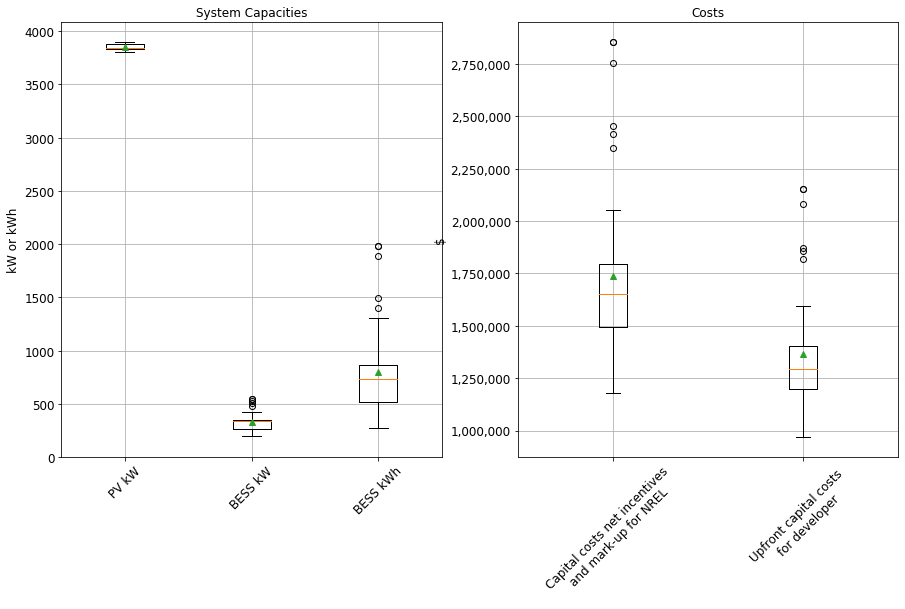

In [42]:
fig, axes = plt.subplots(1,2, figsize=(15, 8))
miny = 0

axes[0].set_title("System Capacities")
bp = axes[0].boxplot([
    pvs_kw, 
    batt_kws,
    batt_kwhs,
], showmeans=True)

ylims = axes[0].get_ylim()
axes[0].set_ylim((miny, ylims[1]))

axes[1].set_title("Costs")
bp = axes[1].boxplot([
    net_capital_costs, 
    upfront_costs
], showmeans=True)

# axes[1].set_ylim((miny, ylims[1]))

for ax in axes:
    ax.grid()

    
axes[0].set_xticklabels(["PV kW", 
                    "BESS kW",
                    "BESS kWh",
                    ], 
                   rotation=45
                  )
axes[0].set_ylabel("kW or kWh", fontsize=BIGGER_SIZE)

axes[1].set_xticklabels(["Capital costs net incentives\n and mark-up for NREL", 
                         "Upfront capital costs \nfor developer"
                    ], 
                   rotation=45
                  )
axes[1].set_ylabel("$", fontsize=BIGGER_SIZE)


axes[1].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# plt.title("time_compare_test_generator_big_enough_for_outage")
#     ax.set_xlim((-500, 500))
plt.savefig(plt_prefix+"_2wk_outages_robust_for_24_per_year.pdf", bbox_inches="tight")

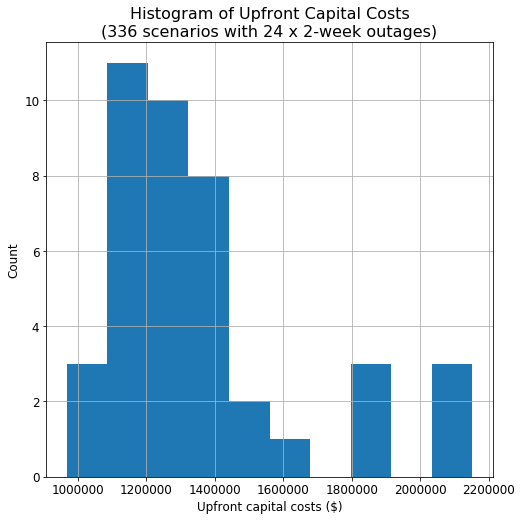

In [43]:
plt.figure(figsize=(8,8))
plt.hist(upfront_costs)
plt.xlabel("Upfront capital costs ($)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Histogram of Upfront Capital Costs\n(336 scenarios with 24 x 2-week outages)",
         fontsize=16)
plt.grid()
plt.savefig(plt_prefix+"_hist_upfront_costs.pdf", bbox_inches="tight")

Notes: 
- upfront capital costs include 30% microgrid cost-adder to the default cost values.
- Cost to NREL includes developer's IRR as well as developer's tax benefits (ITC, MACRS)
- Existing 16 kW of PV is included in the capacities plot (but is not part of costs)

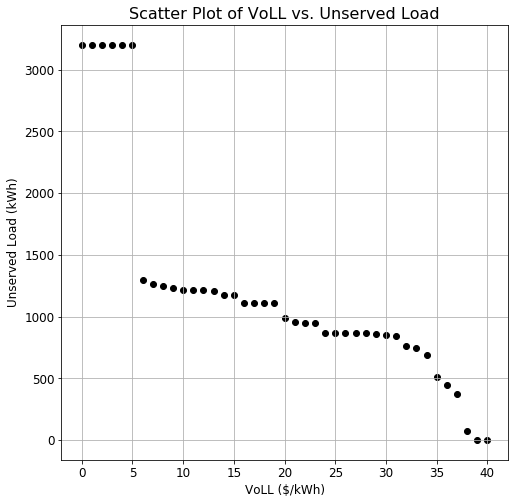

In [44]:
plt.figure(figsize=(8,8))
plt.scatter(VoLL, max_unserved_load_remaining, color = 'black', marker ='o')
plt.xlabel("VoLL ($/kWh)", fontsize=12)
plt.ylabel("Unserved Load (kWh)", fontsize=12)
plt.title("Scatter Plot of VoLL vs. Unserved Load", fontsize=16)
plt.grid()
# plt.savefig(plt_prefix+"_VoLL_vs_unserved_load.pdf", bbox_inches="tight")

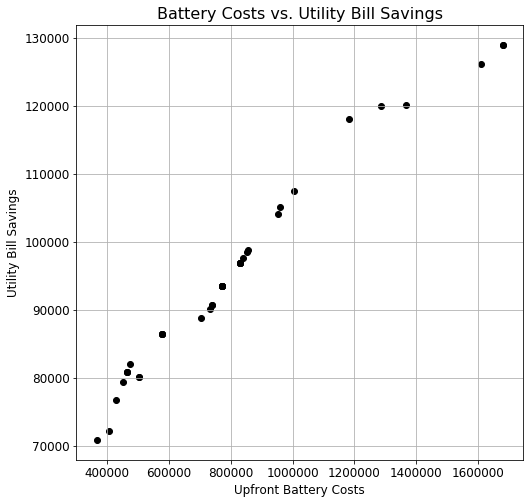

In [45]:
plt.figure(figsize=(8,8))
plt.scatter(batt_upfront_costs, utility_bill_savings, color="black", marker ='o')
plt.xlabel("Upfront Battery Costs", fontsize=12)
plt.ylabel("Utility Bill Savings", fontsize=12)
plt.title("Battery Costs vs. Utility Bill Savings", fontsize=16)
plt.grid()
# plt.savefig(plt_prefix+"_battery_costs_vs_utility_bill_savings.pdf", bbox_inches="tight")

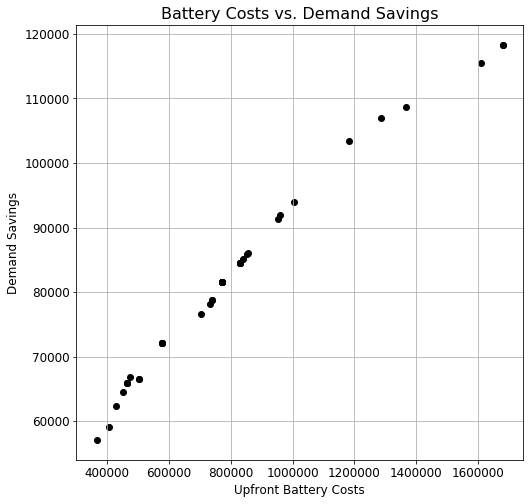

In [46]:
plt.figure(figsize=(8,8))
plt.scatter(batt_upfront_costs, demand_savings, color="black", marker ='o')
plt.xlabel("Upfront Battery Costs", fontsize=12)
plt.ylabel("Demand Savings", fontsize=12)
plt.title("Battery Costs vs. Demand Savings", fontsize=16)
plt.grid()
# plt.savefig(plt_prefix+"_battery_costs_vs_demand_savings.pdf", bbox_inches="tight")

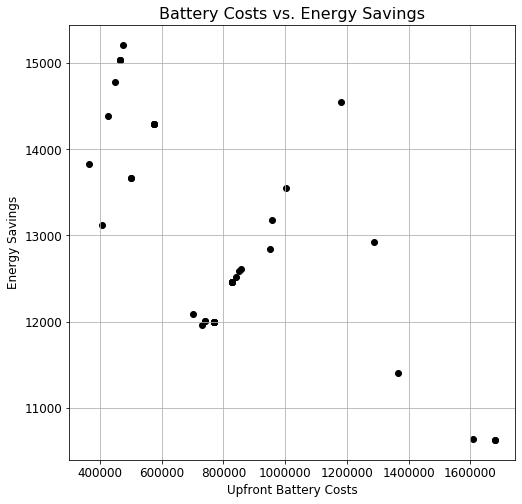

In [47]:
plt.figure(figsize=(8,8))
plt.scatter(batt_upfront_costs, energy_savings, color="black", marker ='o')
plt.xlabel("Upfront Battery Costs", fontsize=12)
plt.ylabel("Energy Savings", fontsize=12)
plt.title("Battery Costs vs. Energy Savings", fontsize=16)
plt.grid()
# plt.savefig(plt_prefix+"_battery_costs_vs_energy_savings.pdf", bbox_inches="tight")

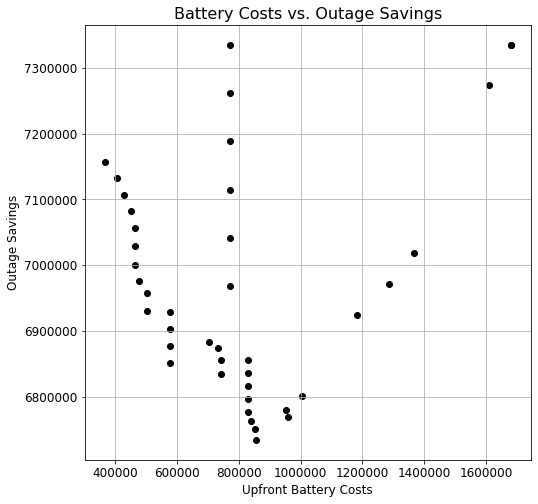

In [15]:
plt.figure(figsize=(8,8))
plt.scatter(batt_upfront_costs, outage_savings, color="black", marker ='o')
plt.xlabel("Upfront Battery Costs", fontsize=12)
plt.ylabel("Outage Savings", fontsize=12)
plt.title("Battery Costs vs. Outage Savings", fontsize=16)
plt.grid()
plt.savefig(plt_prefix+"_battery_costs_vs_outage_savings.pdf", bbox_inches="tight")

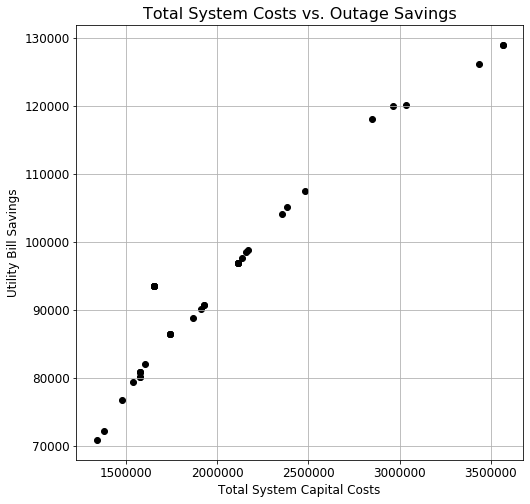

In [55]:
plt.figure(figsize=(8,8))
plt.scatter(total_system_cap_costs, utility_bill_savings, color="black", marker ='o')
plt.xlabel("Total System Capital Costs", fontsize=12)
plt.ylabel("Utility Bill Savings", fontsize=12)
plt.title("Total System Costs vs. Outage Savings", fontsize=16)
plt.grid()
# plt.savefig(plt_prefix+"_system_costs_vs_utility_bill_savings.pdf", bbox_inches="tight")

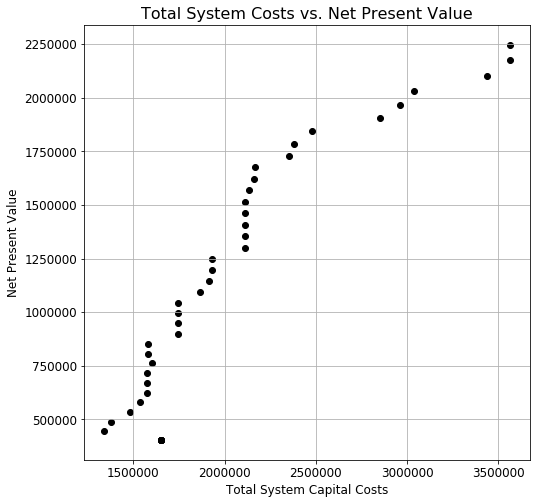

In [49]:
plt.figure(figsize=(8,8))
plt.scatter(total_system_cap_costs, npv, color="black", marker ='o')
plt.xlabel("Total System Capital Costs", fontsize=12)
plt.ylabel("Net Present Value", fontsize=12)
plt.title("Total System Costs vs. Net Present Value", fontsize=16)
plt.grid()
# plt.savefig(plt_prefix+"_system_costs_vs_net_present_value.pdf", bbox_inches="tight")

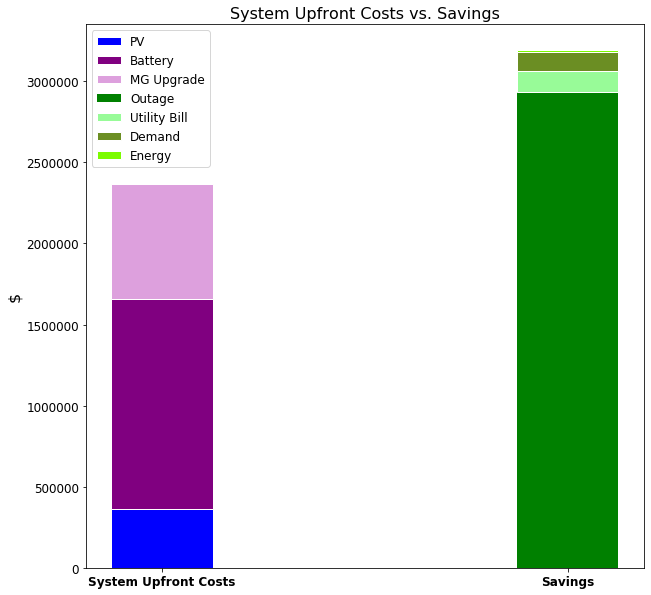

In [54]:
net_pv_upfront_costs = (pv_upfront_costs[40])
bars = np.add(net_pv_upfront_costs, batt_upfront_costs[40]).tolist()
bars2 = np.add(outage_savings[40], utility_bill_savings[40]).tolist()
bars3 = np.add(bars2, demand_savings[40]).tolist()

plt.figure(figsize=(10,10))
r = [0]
s = [1]
names = ["System Upfront Costs", "Savings"]
barwidth = 0.25

plt.bar(r, net_pv_upfront_costs, color='b', edgecolor='white', width=barwidth)
plt.bar(r, batt_upfront_costs[40], bottom=net_pv_upfront_costs, color='purple', edgecolor='white', width=barwidth)
plt.bar(r, mg_upgrade_costs[40], bottom=bars, color='plum', edgecolor='white', width=barwidth)

plt.bar(s, outage_savings[40], color='green', width=barwidth)
plt.bar(s, utility_bill_savings[40], bottom=outage_savings[40], color='palegreen', edgecolor='white', width=barwidth)
plt.bar(s, demand_savings[40], bottom=bars2, color='olivedrab', edgecolor='white', width=barwidth)
plt.bar(s, energy_savings[40], bottom=bars3, color='lawngreen', edgecolor='white', width=barwidth)

plt.xticks(r + s, names, fontweight='bold')
plt.ylabel("$", fontsize=16)
plt.title("System Upfront Costs vs. Savings", fontsize=16)
plt.legend(("PV", "Battery", "MG Upgrade", "Outage", "Utility Bill", "Demand", "Energy"), fontsize = BIGGER_SIZE)
# plt.savefig(plt_prefix+"_system_costs_vs_savings.pdf", bbox_inches="tight")

# chart is representative of case when ALL outage demands are met (outage_cost = 0 when VoLL >= 39 (index 40))
# should pv_upfront_costs be of NET or GROSS PV? current chart is upfront costs of NET PV